# ResNeXt モデルの簡易実装と学習・評価

このノートブックでは、PyTorch を用いて ResNeXt モデルの基本的な構造を理解し、その実装を体験します。
データセットには**実際のCIFAR-10データセット**を使用し、モデルの学習・評価を実践的な設定で行い、ResNeXtがどのように動作するかを素早く確認することを目指します。

**目標:**
- 利用可能なデバイス (CUDA, MPS, CPU) を自動で選択する。
- `torchvision.models` にある ResNeXt モデルをロードし、**CIFAR-10の10クラス分類**用にカスタマイズする。
- **実際のCIFAR-10データセット**をロードし、データローダーを構築する。
- ミニマルな学習ループを構築する。
- モデルのパラメータ数を確認する。
- 学習の進捗を可視化する。

In [2]:
# 必要なライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import CIFAR10 # 実際のCIFAR-10データセットをインポート

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # プログレスバー表示

# モデルのサマリー表示に使うライブラリ (インストールが必要な場合があります)
# `pip install torchinfo` でインストールしてください
try:
    from torchinfo import summary
except ImportError:
    print("-------------------------------------------------------------------------------------")
    print("⚠️ 注意: `torchinfo` が見つかりませんでした。モデルのサマリー表示は簡易的なものになります。")
    print("   `pip install torchinfo` を実行してインストールすることをお勧めします。")
    print("-------------------------------------------------------------------------------------")
    summary = None

print("PyTorchバージョン:", torch.__version__)

PyTorchバージョン: 2.2.2


## 1. デバイスの確認と設定

In [3]:
# --- デバイス設定の条件分岐 ---
# VS Code環境でも、GPUがあればCUDA/MPSが利用可能です。
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU (CUDA) が利用可能です。")
    print("使用するGPU:", torch.cuda.get_device_name(0))
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("GPU (MPS) が利用可能です。")
    print("使用するGPU:", device)
else:
    device = torch.device("cpu")
    print("GPUは利用できません。CPUを使用します。")

print(f"モデルは {device} 上で実行されます。")

GPU (MPS) が利用可能です。
使用するGPU: mps
モデルは mps 上で実行されます。


## 2. データセットの準備 (実際のCIFAR-10データセットを使用)

--- データセット設定 ---
画像サイズ: (3, 32, 32)
クラス数: 10
バッチサイズ: 32
------------------------
画像の前処理パイプラインが定義されました。


100%|██████████| 170498071/170498071 [01:54<00:00, 1492103.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
✅ トレーニングデータセットがロードされました。サンプル数: 50000
Files already downloaded and verified
✅ バリデーションデータセットがロードされました。サンプル数: 10000
--- データローダー情報 ---
トレーニングデータローダーのバッチ数: 1563
バリデーションデータローダーのバッチ数: 313
--------------------------
取得した画像のバッチサイズ: torch.Size([32, 3, 32, 32])
取得したラベルのバッチサイズ: torch.Size([32])

--- ロードされたCIFAR-10データの確認 (最初の数枚) ---


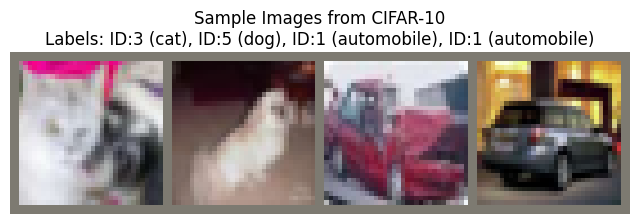

--------------------------------------------------


In [4]:
# データセットのパラメータ設定
image_size = (3, 32, 32) # (チャンネル数, 高さ, 幅) - CIFAR-10のサイズ
num_classes = 10 # 分類するクラス数 - CIFAR-10のクラス数
batch_size = 32 # バッチサイズ

print(f"--- データセット設定 ---")
print(f"画像サイズ: {image_size}")
print(f"クラス数: {num_classes}")
print(f"バッチサイズ: {batch_size}")
print("------------------------")

# 画像変換の定義
# CIFAR-10の標準正規化値を使用
# ResNeXtモデルは通常224x224を想定していますが、ここではCIFAR-10サイズ(32x32)の画像を直接入力します。
# これにより、モデルの入力層のサイズが自動的に調整されるか、エラーになるかを確認できます。
# 実際には、小サイズの画像で大きなモデルをゼロから学習させるのは非常に難しいですが、
# ここではモデルの構造と学習フローを体験することが目的です。
preprocess = transforms.Compose([
    transforms.ToTensor(), # PIL Image/NumPy array (H, W, C) を PyTorch Tensor (C, H, W) に変換し、0-1にスケーリング
    # CIFAR-10の標準正規化値
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])
])
print("画像の前処理パイプラインが定義されました。")

# トレーニングデータセットのロード (初めて実行する際はダウンロードが始まります)
# download=True: データセットがローカルにない場合、自動的にダウンロードします。
# train=True: トレーニングセットをロードします。
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=preprocess)
print(f"✅ トレーニングデータセットがロードされました。サンプル数: {len(train_dataset)}")

# テストデータセットのロード (バリデーションとして使用)
# train=False: テストセットをロードします。
val_dataset = CIFAR10(root='./data', train=False, download=True, transform=preprocess)
print(f"✅ バリデーションデータセットがロードされました。サンプル数: {len(val_dataset)}")

# データローダーの作成
# shuffle=Trueでトレーニングデータをシャッフルし、学習の偏りを防ぐ
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2) # num_workersは環境により調整
# 検証データはシャッフルしない (評価の再現性のため)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"--- データローダー情報 ---")
print(f"トレーニングデータローダーのバッチ数: {len(train_loader)}")
print(f"バリデーションデータローダーのバッチ数: {len(val_loader)}")
print("--------------------------")

# CIFAR-10のクラスラベル (英語に修正)
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# データセットから1バッチ取得して内容を確認
images, labels = next(iter(train_loader))
print(f"取得した画像のバッチサイズ: {images.shape}") # [batch_size, channels, height, width]
print(f"取得したラベルのバッチサイズ: {labels.shape}") # [batch_size]

# 画像を表示するヘルパー関数
def imshow(inp, title=None):
    """TensorをNumPy配列に変換し、画像を表示する"""
    inp = inp.cpu().numpy().transpose((1, 2, 0)) # (C, H, W) -> (H, W, C) に変換

    # 正規化を元に戻す (CIFAR-10の標準正規化の逆)
    mean_val = np.array([0.4914, 0.4822, 0.4465])
    std_val = np.array([0.2471, 0.2435, 0.2616])
    inp = std_val * inp + mean_val

    inp = np.clip(inp, 0, 1) # 0-1の範囲にクリップすることで、表示が適切になる
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off') # 軸を非表示にする
    plt.show(block=False) # 複数画像表示のために非ブロックモード

print("\n--- ロードされたCIFAR-10データの確認 (最初の数枚) ---")
import torchvision # torchvision.utils.make_grid を使うために必要
out = torchvision.utils.make_grid(images[:4]) # 最初の4枚の画像をグリッド表示
plt.figure(figsize=(8, 4))
# ラベルIDと英語名を表示
titles_text = [f"ID:{labels[i].item()} ({cifar10_labels[labels[i].item()]})" for i in range(min(4, len(labels)))]
imshow(out, title=f"Sample Images from CIFAR-10\nLabels: {', '.join(titles_text)}")
print("--------------------------------------------------")

## 3. ResNeXt モデルの定義と準備

In [5]:
# ResNeXt モデルのロードとカスタマイズ
# torchvision.models には様々なResNeXtモデルがありますが、ここでは resnext50_32x4d を使用します。
# weights=None で事前学習済みモデルをロードしない (ゼロから学習するため)
print("--- ResNeXt モデルのロードとカスタマイズ ---")
# ResNet-18のような小規模モデルではないため、CIFAR-10のような小画像サイズではそのままでは性能が出にくい場合があります。
# しかし、ここではResNeXtの構造を体験することに主眼を置きます。
model = models.resnext50_32x4d(weights=None) # 事前学習済み重みはロードしない

# モデルの最終層 (全結合層: fc) を、CIFAR-10のクラス数 (10) に合わせて変更します。
# ImageNetで事前学習済みのモデルを使用する場合でも、通常は最終層の変更が必要です。
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes) # num_classes は 10 に設定されています

model.eval() # 評価モードに設定 (初期状態での推論のために)
model = model.to(device)

print(f"ResNeXt-50モデルがロードされ、最終層が {num_classes} クラス用に設定されました。")
print(f"モデルは {device} 上で実行されます。")
print("--------------------------------------------------")

--- ResNeXt モデルのロードとカスタマイズ ---
ResNeXt-50モデルがロードされ、最終層が 10 クラス用に設定されました。
モデルは mps 上で実行されます。
--------------------------------------------------


In [6]:
# モデルのサマリーとパラメータ数を表示
if summary: # torchinfoが正常にインポートされた場合
    print("\n--- モデルのサマリー情報 --- ")
    # summary関数を使ってモデルの構造とパラメータ数を表示
    # input_sizeはモデルに入力されるテンソルの形状 (バッチサイズ, チャンネル, 高さ, 幅)
    print(summary(model, input_size=(batch_size, image_size[0], image_size[1], image_size[2])))
    print("--------------------------------------------------")
else: # torchinfoがインポートできなかった場合
    # torchinfoがない場合の簡易的なパラメータ数表示
    print(f"--- モデルの簡易パラメータ情報 ---")
    print(model) # モデルオブジェクトをprintすることで、その構造が表示される
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"学習可能なパラメータ総数: {total_params:,}")
    print("------------------------------------")


--- モデルのサマリー情報 --- 
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 16, 16]          9,408
├─BatchNorm2d: 1-2                       [32, 64, 16, 16]          128
├─ReLU: 1-3                              [32, 64, 16, 16]          --
├─MaxPool2d: 1-4                         [32, 64, 8, 8]            --
├─Sequential: 1-5                        [32, 256, 8, 8]           --
│    └─Bottleneck: 2-1                   [32, 256, 8, 8]           --
│    │    └─Conv2d: 3-1                  [32, 128, 8, 8]           8,192
│    │    └─BatchNorm2d: 3-2             [32, 128, 8, 8]           256
│    │    └─ReLU: 3-3                    [32, 128, 8, 8]           --
│    │    └─Conv2d: 3-4                  [32, 128, 8, 8]           4,608
│    │    └─BatchNorm2d: 3-5             [32, 128, 8, 8]           256
│    │    └─ReLU: 3-6                    [32, 128, 8

## 4. 損失関数、最適化手法、学習ループ

In [8]:
# ハイパーパラメータの設定
num_epochs = 20 # 学習エポック数 (CIFAR-10データセットでも、ResNeXtのような深いモデルではより多くのエポックが必要な場合があります)
learning_rate = 0.001 # 学習率

print(f"--- 学習設定 ---")
print(f"エポック数: {num_epochs}")
print(f"学習率: {learning_rate}")
print("----------------")

# 損失関数の定義
criterion = nn.CrossEntropyLoss()
print(f"損失関数: {criterion.__class__.__name__} を使用します。")

# 最適化手法の定義
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"最適化手法: {optimizer.__class__.__name__} を使用します。")
print("----------------------------")

# モデルをデバイスに移動
model = model.to(device)

# 学習のログを保存するリスト
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("\n--- 学習開始 ---")
for epoch in range(num_epochs):
    # 各エポックのトレーニングフェーズ
    model.train() # モデルをトレーニングモードに設定
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    # 各エポックのバリデーションフェーズ
    model.eval() # モデルを評価モードに設定
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
    epoch_val_loss = running_val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

print("--- 学習完了 ---")

--- 学習設定 ---
エポック数: 20
学習率: 0.001
----------------
損失関数: CrossEntropyLoss を使用します。
最適化手法: Adam を使用します。
----------------------------

--- 学習開始 ---


Epoch 1/20 [Validation]: 100%|██████████| 313/313 [00:40<00:00,  7.66it/s]


Epoch 1/20: Train Loss: 1.9792, Train Acc: 36.01% | Val Loss: 1.9573, Val Acc: 41.93%


Epoch 2/20 [Train]:  78%|███████▊  | 1217/1563 [07:27<02:07,  2.72it/s]

: 

## 5. 学習結果の可視化と推論

In [ ]:
# 学習履歴の可視化
print("--- 学習履歴 (損失と精度) の可視化 ---")
plt.figure(figsize=(12, 5))

# 損失グラフ
plt.subplot(1, 2, 1) # 1行2列の1番目のサブプロット
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 精度グラフ
plt.subplot(1, 2, 2) # 1行2列の2番目のサブプロット
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout() # サブプロット間の余白を自動調整
plt.show()
print("---------------------------------------")

# 簡単な推論の実行 (バッチでの推論)
print("\n--- 簡単な推論の実行 (バッチ) ---")
model.eval() # モデルを評価モードに設定

# 検証データローダーから1バッチ取得
images, labels = next(iter(val_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    output = model(images)
    probabilities = torch.nn.functional.softmax(output, dim=1) # バッチ全体でsoftmax
    _, predicted = torch.max(probabilities, 1) # 各サンプルで最も高い確率のクラスを取得

# 最初の数枚の画像と予測結果を表示
fig = plt.figure(figsize=(10, 6))
fig.suptitle('Sample Predictions', fontsize=16)

for i in range(min(4, len(images))): # 最初の4枚（またはそれ以下）の画像を表示
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    imshow(images.cpu()[i]) # CPUに戻して表示
    ax.set_title(f"True: {cifar10_labels[labels[i].item()]}\nPred: {cifar10_labels[predicted[i].item()]}",
                 color=("green" if predicted[i] == labels[i] else "red"))
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # タイトルとサブプロットが重ならないように調整
plt.show()

print("--- 推論完了 (バッチ) ---")
print("\nこれで、ResNeXtモデルのロード、CIFAR-10データセットでの学習、そして簡単な評価までの一連の流れを体験できました。")
print("ResNeXtのような深いモデルをCIFAR-10のような小さな画像でゼロから学習させるのは難しいですが、")
print("モデルの構造と学習フローを理解する上での良い出発点となります。")
print("より詳細な理論については `docs/02_Theory/` を、実装の解説は `docs/03_Implementation/02_ResNeXt_Implementation_and_Explanation.md` を参照してください。")

## 6. 特定の画像に対する推論の確認

学習したモデルが、個別の画像に対してどのように予測を行うのかを確認しましょう。
ここでは、CIFAR-10のテストデータからランダムに1枚の画像を選び、モデルに分類させます。

In [ ]:
print("\n--- 特定の画像に対する推論 ---")

# CIFAR-10のテストデータセットからランダムに1枚の画像を選択
# val_datasetはCIFAR-10のテストセットをロードしています
random_idx = np.random.randint(0, len(val_dataset)) # テストセットからランダムなインデックスを選ぶ
random_image, true_label_id = val_dataset[random_idx] # 画像と正解ラベルのIDを取得

print(f"テストセットからランダムに選択された画像 (インデックス: {random_idx})")
print(f"正解ラベル (ID): {true_label_id} -> {cifar10_labels[true_label_id]}")

# 画像を表示 (前処理後のテンソルを逆変換して表示)
plt.figure(figsize=(4, 4))
# タイトルもID表示に
imshow(random_image, title=f"True ID: {true_label_id} ({cifar10_labels[true_label_id]})")
plt.show()

# モデルに入力するための準備
# バッチ次元を追加 (3, 32, 32) -> (1, 3, 32, 32)
input_single_batch = random_image.unsqueeze(0)
input_single_batch = input_single_batch.to(device) # モデルと同じデバイスへ移動

# 推論の実行
model.eval() # モデルを評価モードに設定
with torch.no_grad(): # 勾配計算を無効化
    output_single = model(input_single_batch)

# 予測結果の処理
probabilities_single = torch.nn.functional.softmax(output_single[0], dim=0) # 単一画像の確率なのでoutput[0]
top1_prob, top1_catid = torch.topk(probabilities_single, 1) # 最も確率の高いクラスを取得

predicted_label_id = top1_catid.item()
predicted_probability = top1_prob.item()

print("\n--- 推論結果 ---")
print(f"予測クラス (ID): {predicted_label_id} ({cifar10_labels[predicted_label_id]})") # ここもIDと英語名
print(f"予測確率: {predicted_probability:.4f}")

# 正解か不正解かの表示
if predicted_label_id == true_label_id:
    print("✅ モデルは正しく分類しました！")
else:
    print(f"❌ モデルは誤って分類しました。正解は '{cifar10_labels[true_label_id]}' (ID: {true_label_id}) です。")

print("----------------------------------")
print("これで、モデルが個々の画像に対してどのように「判断」を下しているかを直接確認できました。")
print("特に、学習が進むにつれて正解率が向上する様子が、この単一推論でも実感できるはずです。")